<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook 3</p></tp>
            <tp><p style="font-size:150%;text-align:center">Búsqueda en espacio de estados (2/3) </p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

## Objetivo <a class="anchor" id="inicio"></a>

En este notebook vamos a expandir el abanico de algoritmos de búsqueda a ciegas en un espacio de estados. Comenzaremos implementando los algoritmos `depth_limited_search` e `iterative_deepening_search` y los aplicaremos a la solución de problemas. 

Para seguir aumentando el abanico, necesitaremos considerar el costo del camino a seguir. Para ello, vamos a definir una lista prioritaria y mostraremos una posible implementación en Python. Analizaremos también la manera en la cual tanto el ambiente de tarea como el árbol de búsqueda involucran el costo de las acciones. 

Posteriormente, definiremos el algoritmo general de búsqueda basada en funciones de evaluación, llamado `best_first_search` para encontrar la solución más eficiente en el problema de las jarras de agua.

Finalmente, usaremos los cuatro métodos para comparar su eficiencia en la búsqueda de una solución para el problema del laberinto.

Adaptado de (Russell & Norvig, 2020), secciones 3.3 y 3.4.4.

## Secciones

Desarrollaremos la explicación de la siguiente manera:

* [Estrategia de búsqueda depth limited](#limited).
* [Estrategia de búsqueda iterative deepening](#iterative).
* [Comparación de tiempos](#compara).
* [Listas prioritarias](#listas).
* [Costos](#costos).
* [Estrategia de búsqueda best first search](#best).
* [Problema del laberinto](#laberinto).



## Depth limited search <a class="anchor" id="limited"></a>
    
([Volver al inicio](#inicio))
    
En el notebook anterior hemos visto un algoritmo recursivo de `backtracking_search` que funcionaba bien en el caso de las 8 reinas, pero que superaba el umbral de memoria en el problema de las jarras de agua. Esta dificultad residía en el hecho de que el camino de búsqueda puede generar ciclos, lo cual conlleva a que el algoritmo se quede atascado en un bucle infinito. La solución que dimos en su momento fue el algoritmo `depth_first_search`, el cual lleva la cuenta de cuáles estados se exploran, de tal manera que no se vuelva a explorar uno ya explorado.

Un compromiso entre la solución eficiente en memoria del `backtracking_search` y del efectivo `depth_first_search` es el `depth_limited_search`. En este algoritmo tendremos una profundidad límite para los nodos, que nunca podremos superar. Además, no guardaremos en memoria una lista de cuáles estados ya revisamos, sino que usaremos una función para verificar si el nodo que estamos explorando se generó mediante un camino cíclico. 

La complejidad en tiempo de este algoritmo es, en el peor de los casos, igual a los algoritmos `depth_first_search` y `breadth_first_search`. No obstante, el hecho de no guardar una lista de explorados hace que la complejidad en memoria sea lineal, es decir, mucho mejor que la de aquellos algoritmos. 


**Altura de un nodo en el árbol de búsqueda**

Antes de mirar el pseudocódigo del algoritmo, consideremos con más detalle cómo encontrar la profundidad de un nodo y cómo verificar si proviene de un camino cíclico.

La profundidad de un nodo, también conocida como su altura, es la cantidad de aristas desde la raíz hasta él. Por tanto, la raíz tiene profundidad 0, sus hijos tienen profundidad 1, los hijos de sus hijos tienen profundidad 2, etc.

Recuerde que un nodo es un objeto con atributos `estado`, `madre`, `accion`, `costo_camino`, `codigo`.


In [44]:
from ambientes import JarrasAgua
from busqueda import *
import time

<a class="anchor" id="ej1"></a>**Ejercicio 1:** 

([Próximo ejercicio](#ej2))

Implemente la función recursiva `depth` que recibe un nodo y retorna su altura. Pruebe su solución con el siguiente nodo `n3`, cuya profundidad debe ser, obviamente, 3:

In [45]:
prob = JarrasAgua()
s = prob.estado_inicial
n = Nodo(s, None, None, 0, prob.codigo(s))
n1 = nodo_hijo(prob, n, 1)
n2 = nodo_hijo(prob, n1, 5)
n3 = nodo_hijo(prob, n2, 6)

---

In [46]:
def depth_(node: Nodo):
    
    if node.madre == None:
        return 0
    
    return 1 + depth_(node.madre)   

In [47]:
print("depth node {}".format(depth_(n3)))
print("depth node {}".format(depth_(n2)))
print("depth node {}".format(depth_(n1)))

depth node 3
depth node 2
depth node 1


<a class="anchor" id="ej2"></a>**Ejercicio 2:** 

([Anterior ejercicio](#ej1)) ([Próximo ejercicio](#ej3))

Implemente la función `is_cycle` que toma un nodo y devuelve un valor de verdad, dependiendo de si el camino de estados que va desde la raíz hasta él tiene ciclos. Pruebe su función con el nodo `n3` definido anteriormente, para el cual `is_cycle` debe ser verdadero. 

**Ayuda:** Pruebe definiendo primero una función recursiva que encuentra los códigos de todos los estados en el camino y luego verifica si hay repetidos.

---

In [48]:
def get_codes(node: Nodo):
    
    if node.madre == None:
        return [node.codigo]
    
    return  [] + [node.codigo] + get_codes(node.madre)

In [6]:
def is_cycle(node: Nodo):
    
    return len( set(get_codes(node)) ) != len(get_codes(node))

In [7]:
is_cycle(n3)

True

El siguiente es el pseudocódigo del algoritmo de búsqueda `depth_limited_search`:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> depth_limited_search(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">l</font>) <font style="font-weight: bold;" color = "red">returns</font> solución o falla o cutoff <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">problema</font>.estado_inicial) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista LIFO con <font style="font-style: italic;">nodo</font> como único elemento <br>
&nbsp;&nbsp; <font style="font-style: italic;">resultado</font> &#8592; falla <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> DEPTH(<font style="font-style: italic;">nodo</font>) &#62;= <font style="font-style: italic;">l</font> <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">resultado</font> &#8592; cutoff <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">else if not</font> IS_CYCLE(<font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">hijo</font> <font style="font-weight: bold;" color = "red">in</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ADD(<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">frontera</font>)<br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> <font style="font-style: italic;">resultado</font>  <br>
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodos</font> <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">nodo</font>.estado <br>
&nbsp;&nbsp;  <font style="font-style: italic;">nodos</font> &#8592; lista LIFO vacía <br>
&nbsp;&nbsp;  <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">accion</font> <font style="font-weight: bold;" color = "red">in</font> <font style="font-style: italic;">problema</font>.acciones_aplicables(<font style="font-style: italic;">s</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;  <font style="font-style: italic;">hijo</font> &#8592; nodo_hijo(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>, <font style="font-style: italic;">accion</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; ADD(<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">nodos</font>)<br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> nodos <br>
</div>

Hay dos anotaciones importantes que debemos mencionar aquí. Observe que para expandir un nodo se está usando una lista obtenida mediante la función `expand`, la cual proporciona todos los nodos hijo que se obtienen a partir de un nodo madre mediante cada una de las acciones aplicables. Además, la verificación de la prueba de satisfacción de objetivo se realiza al explorar la frontera, no al expandir un nodo. Sobre esto volveremos más adelante.


<a class="anchor" id="ej3"></a>**Ejercicio 3:** 

([Anterior ejercicio](#ej2)) ([Próximo ejercicio](#ej4))

Implemente el algoritmo de búsqueda `depth_limited_search` e intente resolver el problema de las jarras de agua a profundidad 4, 5, 6 y 10. En las dos primeras profundidades debe fallar y ser exitoso en las dos últimas. Observe, no obstante, que la solución a profundidad 6 debe ser distinta que la solución a profundidad 10. ¿Por qué?

---

In [8]:
def expand(problema, node):
    
    state = node.estado
    nodes = []
    
    for action in problema.acciones_aplicables(state):
        child = nodo_hijo(problema, node, action)
        nodes.append(child)
        
    return nodes
    

In [9]:
def depth_limited_search(problema, l):
    
    node = Nodo(estado = problema.estado_inicial,
                madre  = None,
                accion = None, 
                costo_camino = 0,
                codigo = 'origin')
    
    frontier  = [node]
    result = "falla"
    
    while len(frontier) > 0:
        
        node = frontier.pop(0)
        
        if problema.test_objetivo(node.estado):
            return node
        
        if depth_(node) >= l:
            return "cutoff"
        
        elif not is_cycle(node):
            
            for child in expand(problema, node):
                frontier.append(child)
                
    return result

In [10]:
prob = JarrasAgua()

ntrials = 150
times   = []
depth = 7

for i in range (ntrials):

    start = time.time()
    ans = depth_limited_search(prob, depth)
    end = time.time()
    
    times.append(end - start)

In [11]:
prob.test_objetivo(ans.estado)

True

Text(0, 0.5, 's')

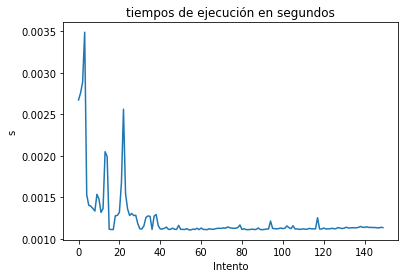

In [12]:
from matplotlib import pyplot as plt

plt.plot(times)
plt.title("tiempos de ejecución en segundos")
plt.xlabel("Intento")
plt.ylabel("s")

## Iterative deepening search <a class="anchor" id="iterative"></a>

([Volver al inicio](#inicio))

Cuando no conocemos la profundidad a la que se encuentra la solución, dar un límite cualquiera puede no ser adecuado. Por ejemplo, podemos dar una profundidad muy pandita y corremos el riesgo de no encontrar la solución. O, como ocurrió en el caso anterior, una profundidad muy grande resulta en soluciones poco óptimas. Resulta más sistemático ejecutar esta búsqueda intentando todas las profundidades: primero profundidad 0, luego 1, luego 2, etc. De esta manera, podremos tener la seguridad de encontrar la solución óptima (a menor profundidad). 

El siguiente es un esquema de este algoritmo de búsqueda:

<img src="./imagenes/iterative-deepening1.png" width="auto"/>

Y el siguiente es el pseudocódigo respectivo:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> iterative_deepening_search(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">l_max</font>) <font style="font-weight: bold;" color = "red">returns</font> solución o falla <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">For</font> <font style="font-style: italic;">depth</font> = 0 <font style="font-weight: bold;" color = "red">to</font> <font style="font-style: italic;">l_max</font> <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">resultado</font> &#8592; depth_limited_search(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">depth</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">resultado</font> &#8800; cutoff <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">resultado</font> <br>
</div>


<a class="anchor" id="ej4"></a>**Ejercicio 4:** 

([Anterior ejercicio](#ej3)) ([Próximo ejercicio](#ej5))

Implemente la función `iterative_deepening_search`y resuelva el problema de las jarras de agua con profundidad máxima 10. Observe que en este caso debe obtener la solución óptima a profundidad 6.

---

In [13]:
def  iterative_deepening_search(problema, l_max):

    for depth in range(l_max):
        ans =  depth_limited_search(problema, depth)

        if type(ans) != type(""):
            return (ans, depth)
        

In [14]:
iterative_deepening_search(prob, 710)

(<busqueda.Nodo at 0x7f14e4a4c9d0>, 7)

## Comparación empírica de tiempos <a class="anchor" id="compara"></a>

([Volver al inicio](#inicio))

La eficiencia de los algoritmos es un tema central en las ciencias de la computación. Esta eficiencia se estudia usalmente de manera teórica, respecto al tiempo y memoria que consume un algoritmo al correr en un modelo de computación respecto a varios tipos de entradas. En este curso seguiremos un enfoque empírico para evaluar la eficiencia de los algoritmos. Este enfoque no reemplaza el teórico y es sólo una aproximación al mismo. 

Lo que deseamos hacer es evaluar los tiempos que le lleva al computador ejecutar alguno de nuestros algoritmos sobre una colección de entradas. En este caso particular, como tenemos varias funciones que realizan el mismo procedimiento, resulta interesante evaluar de manera empírica cuál es más rápida. 

Observe que medir los tiempos del computador no es el enfoque más apropiado para considerar la eficiencia, pero de todas maneras resulta útil. Para realizar esto debemos tener presente que el computador es una pieza de hardware cuyos tiempos de funcionamiento dependen de muchas cosas (nivel de energía, estado del hardware, etc.). Además, un computador realiza muchas tareas al mismo tiempo. En consecuencia, medir los tiempos del computador para evaluar una función requiere tratar de cancelar todo este ruido alrededor. Una manera de hacerlo es obtener varias mediciones del mismo proceso, y luego comparar promedios de tiempos. Esto es lo que realizaremos a continuación. 

Creamos primero una función que obtiene una lista con varias mediciones del tiempo de ejecución de una función. Analice la siguiente celda hasta que se sienta satisfecho con su comprensión del código:

In [15]:
from time import time

def obtiene_tiempos(fun, args, num_it=100):
    tiempos_fun = []
    for i in range(num_it):
        arranca = time()
        x = fun(*args)
        para = time()
        tiempos_fun.append(para - arranca)
    return tiempos_fun

Ahora creamos una función que obtiene estos tiempos y guardarlos en un dataframe de pandas:

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

def compara_funciones(funs, arg, nombres, N=30):
    nms = []
    ts = []
    for i, fun in enumerate(funs):
        nms += [nombres[i] for x in range(N)]
        ts  += obtiene_tiempos(fun, [arg], N)
    data = pd.DataFrame({'Función':nms, 'Tiempo':ts})
    return data
    

Con esta información, ahora podemos graficar las distribuciones de tiempos y realizar la prueba ANOVA para diferencia de medias:

              sum_sq     df            F         PR(>F)
C(Función)  0.000168    3.0  2834.351564  2.605993e-108
Residual    0.000002  116.0          NaN            NaN


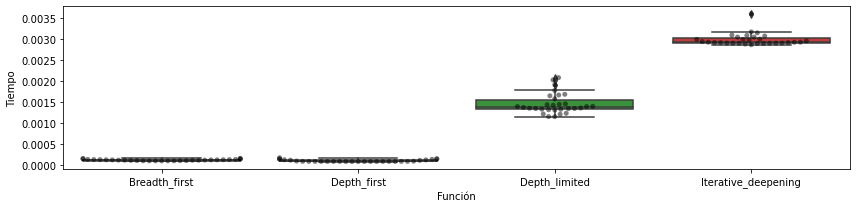

In [17]:
from busqueda import *
import warnings
warnings.filterwarnings('ignore')

funs = [breadth_first_search,
        depth_first_search,
        lambda x: depth_limited_search(x, 10),
        lambda x: iterative_deepening_search(x, 10)
]
nombres = ['Breadth_first', 'Depth_first', 
           'Depth_limited', 'Iterative_deepening']

prob = JarrasAgua()
data = compara_funciones(funs=funs, arg=prob, nombres=nombres)

# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data, x='Función', y='Tiempo')
sns.swarmplot(data=data, x='Función', y='Tiempo', color='black', alpha = 0.5, ax=ax);

# Anova diferencia de medias
model = ols('Tiempo ~ C(Función)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

Observe que la prueba de anova para la diferencia de medias nos muestra que, para el problema de las jarras de agua, hay evidencia para afirmar que los tiempos promedio de los cuatro algoritmos son diferentes (F(3,116)=772, p<.001).

In [18]:
data.groupby('Función').agg({'Tiempo':['mean', 'std']})

Tiempo          
                         mean       std
Función                                
Breadth_first        0.000128  0.000017
Depth_first          0.000110  0.000026
Depth_limited        0.001460  0.000240
Iterative_deepening  0.002986  0.000142

Adicionalmente, los resultados indican que la función de búsqueda de iterative deepening es mucho más demorada que las otras tres funciones, y que la función ganadora es depth first search, siendo la más rápida en resolver el problema de las jarras de agua, con un tiempo promedio de $0.083$ milisegundos.

---

## Listas prioritarias <a class="anchor" id="listas"></a>

([Volver al inicio](#inicio))

En una lista prioritaria, los elementos tienen una prioridad de acuerdo al valor que reciben por una función de evaluación $f$. De esta manera, la acción POP remueve y retorna el elemento prioritario, que es aquel con valor mínimo de $f$. Cuando dos elementos tienen la misma prioridad, el último elemento en ser incluido es el primero en salir.

Existen librerías que proporcionan objetos que implementan listas prioritarias, como <a href="https://pypi.org/project/HeapDict/">heapdict</a>. Aquí utilizaremos el siguiente objeto `ListaPrioritaria` para implementar las listas prioritarias:

In [19]:
import numpy as np

class ListaPrioritaria():
    
    def __init__(self):
        self.diccionario = {}
        
    def __str__(self):
        cadena = '['
        inicial = True
        for costo in self.diccionario:
            elementos = self.diccionario[costo]
            for elemento in elementos:
                if inicial:
                    cadena += '(' + str(elemento) + ',' + str(costo) + ')'
                    inicial = False
                else:
                    cadena += ', (' + str(elemento) + ',' + str(costo) + ')'

        return cadena + ']'
    
    def push(self, elemento, costo):
        try:
            self.diccionario[costo].append(elemento)
        except:
            self.diccionario[costo] = [elemento]
            
    def pop(self):
        min_costo  = min(list(self.diccionario.keys()))
        candidatos = self.diccionario[min_costo]
        elemento   = candidatos.pop()
        
        if len(candidatos) == 0:
            del self.diccionario[min_costo]
        return elemento
    
    def is_empty(self):
        return len(self.diccionario) == 0
        

La idea detrás de este objeto es mantener un diccionario con los costos como keys, y los valores como listas de elementos que tienen el costo del respectivo key. De esta manera, al llamar el método `pop`, se busca la key mínima y se hace pop a la lista que es su respectivo valor de acuerdo al diccionario.

Vamos a incluir algunos elementos en nuestra lista. Observe que incluimos las prioridades manualmente, sin recurrir a una función $f$:

In [20]:
lista = ListaPrioritaria()
lista.push('g', 2)
lista.push('e', 3)
lista.push('k', 1)
lista.push('s', 2)
print("La lista prioritaria:", lista)

La lista prioritaria: [(g,2), (s,2), (e,3), (k,1)]


Observe que los elementos no se visualizan en orden. Tampoco se visualiza la forma real del diccionario, la cual se puede observar así:


In [21]:
print("El diccionario subyacente:", lista.diccionario)

El diccionario subyacente: {2: ['g', 's'], 3: ['e'], 1: ['k']}


A pesar de que los valores no están en orden, el método `pop` devuelve el elemento prioritario:

In [22]:
n = lista.pop()
n

'k'

Observe que tanto 'g' como 's' tienen la misma prioridad. No obstante, 's' fue el último en ser incluido en `lista` y, por lo tanto, es el primero en salir:


In [23]:
print("La lista prioritaria:", lista)
print("Al hacer pop con dos elementos con el mismo valor se obtiene:", lista.pop())

La lista prioritaria: [(g,2), (s,2), (e,3)]
Al hacer pop con dos elementos con el mismo valor se obtiene: s


Para determinar si la lista prioritaria está vacía, usamos el método `is_empty`.

In [24]:
print("La lista prioritaria:", lista)
print("Lista vacía?", lista.is_empty())

La lista prioritaria: [(g,2), (e,3)]
Lista vacía? False


Antes de que podamos utilizar listas prioritarias en nuestras búsquedas dentro de espacios de estados, debemos entender un poco más la manera mediante la cual se ha implementado un costo a una acción en un estado dado dentro de nuestros ambientes de tarea. Esto es lo que vamos a ver a continuación.

## Costos <a class="anchor" id="costos"></a>

([Volver al inicio](#inicio))

**El método costo**

En este apartado veremos la manera mediante la cual los ambientes de tarea involucran una función de costo, que le asigna un costo a una acción en un estado dado. Comencemos por ver esto en nuestro problema de las jarras de agua.

Acciones aplicables: [1, 2]


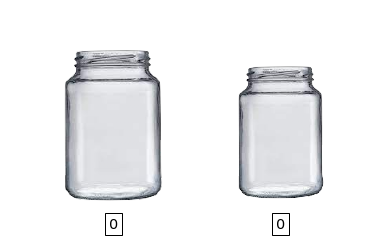

In [25]:
prob = JarrasAgua()
s = prob.estado_inicial
prob.pintar_estado(s)
print("Acciones aplicables:", prob.acciones_aplicables(s))

In [26]:
print("Costo de aplicar la accion 1 a s es", prob.costo(s, 1))
print("Costo de aplicar la accion 2 a s es", prob.costo(s, 2))

Costo de aplicar la accion 1 a s es 1
Costo de aplicar la accion 2 a s es 1


Como podemos ver, el ambiente de tarea tiene un método `costo()`, que permite asignar un costo a una acción en un estado dado. Al revisar el código en la librería ambientes, podemos observar que este método está definido de la siguiente manera:

In [27]:
def costo(self, estado, accion):
    return 1

# setattr(JarrasAgua,"costo", costo)

Esto es, se le asigna el mismo costo unitario a cualquier acción aplicable en cualquier estado.

**El atributo costo_camino**

Además de este método asociado a un ambiente de tarea, tenemos también el atributo `costo_camino` de los objetos `Nodo`. Repetimos aquí la definición de los nodos para poder observar un aspecto importante.

In [28]:
class Nodo:
    
    # Clase para crear los nodos
    
    def __init__(self, estado, madre, accion, costo_camino, codigo):
        self.estado = estado
        self.madre = madre
        self.accion = accion
        self.costo_camino = costo_camino
        self.codigo = codigo
        
def nodo_hijo(problema, madre, accion):
    
    # Función para crear un nuevo nodo
    # Input: problema, que es un objeto de clase ocho_reinas
    #        madre, que es un nodo,
    #        accion, que es una acción que da lugar al estado del nuevo nodo
    # Output: nodo
    
    estado = problema.transicion(madre.estado, accion)
    costo_camino = madre.costo_camino + problema.costo(madre.estado, accion)
    codigo = problema.codigo(estado)
    
    return Nodo(estado, madre, accion, costo_camino, codigo)

def solucion(n):
    if n.madre == None:
        return []
    else:
        return solucion(n.madre) + [n.accion]

Observe que la función `nodo_hijo` crea un nodo hijo al expandir el nodo madre mediante una acción `s`. Al momento de crear el hijo se calcula su `costo_camino`, que consiste en el `costo_camino` del nodo madre más el costo que el ambiente de tarea le atribuye a la acción `s` en el estado del nodo madre.

Veamos esto con un ejemplo:

In [29]:
n = Nodo(s, None, None, 0, prob.codigo(s))
n1 = nodo_hijo(prob, n, 1)
n2 = nodo_hijo(prob, n1, 5)
n3 = nodo_hijo(prob, n2, 3)
print("Costo camino de n =", n.costo_camino)
print("Costo camino de n1 =", n1.costo_camino)
print("Costo camino de n2 =", n2.costo_camino)
print("Costo camino de n3 =", n3.costo_camino)

Costo camino de n = 0
Costo camino de n1 = 1
Costo camino de n2 = 2
Costo camino de n3 = 3


En este caso el costo camino coincide con el número de acciones que se necesitan para generar el nodo desde la raíz, toda vez que cada acción tiene costo de 1.

**Modificar el método costos**

Para un problema dado, debe ser claro que podemos definir distintos métodos de costo. En nuestro problema, en lugar del costo unitario que hemos visto anteriormente, podríamos definir un costo basado en el uso eficiente del agua. Por ejemplo, podemos definir la siguiente función, la cual calcula cuánta agua se utilizó para llenar las jarras y se le suma el agua que se desperdició (otros cálculos distintos, basados en otros criterios, son posibles): 

In [30]:
def desperdicio(self, estado, accion):
    x, y = estado
    if accion == 1:
        costo = 4 - x # usa 4-x litros de agua
    if accion == 2:
        costo = 3 - y # usa 3-y litros de agua
    if accion == 3:
        costo = x # desperdicia x litros de agua
    if accion == 4:
        costo = y # desperdicia y litros de agua
    if accion == 5:
        costo = 0
    if accion == 6:
        costo = 0
    return costo


Ahora podemos añadirla para reemplazar el método `costo` del problema de las jarras de agua:

In [31]:
setattr(JarrasAgua, "costo", desperdicio)

Observe cómo se modifican los `costo_camino` de los mismos nodos que hemos revisado hace un momento:

In [32]:
prob = JarrasAgua()
s = prob.estado_inicial
n = Nodo(s, None, None, 0, prob.codigo(s))
n1 = nodo_hijo(prob, n, 1)
n2 = nodo_hijo(prob, n1, 5)
n3 = nodo_hijo(prob, n2, 3)
print("Costo camino de n =",  n.costo_camino)
print("Costo camino de n1 =", n1.costo_camino)
print("Costo camino de n2 =", n2.costo_camino)
print("Costo camino de n3 =", n3.costo_camino)

Costo camino de n = 0
Costo camino de n1 = 4
Costo camino de n2 = 4
Costo camino de n3 = 5


<a class="anchor" id="ej5"></a>**Ejercicio 5:** 

([Anterior ejercicio](#ej4)) ([Próximo ejercicio](#ej6))

Cree una lista prioritaria `frontera` con los cuatro nodos anteriores y su respectivo `costo_camino` (obtenido mediante el atributo respectivo, no incluido a mano). Devuelva el código del estado con mínimo costo.

---

In [33]:
frontera = ListaPrioritaria()
frontera.push(n,  n.costo_camino)
frontera.push(n1, n1.costo_camino)
frontera.push(n2, n2.costo_camino)
frontera.push(n3, n3.costo_camino)
print("La lista prioritaria:", frontera)

La lista prioritaria: [(<__main__.Nodo object at 0x7f14f824cd30>,0), (<__main__.Nodo object at 0x7f14f824c7f0>,4), (<__main__.Nodo object at 0x7f14f824c3d0>,4), (<__main__.Nodo object at 0x7f14f824cfd0>,5)]


In [34]:
frontera.pop().codigo

'0-0'

## Best first search <a class="anchor" id="best"></a>

([Volver al inicio](#inicio))

Ya estamos listos para presentar el algoritmo general de búsqueda `best_first_search`, también conocido como el algoritmo de Dijkstra (se pronuncia "daecstra"). Todos los algoritmos de búsqueda subsiguientes serán un caso particular de este. Solamente modificaremos la función de evaluación $f$. En algunos casos será una función de costos, en otros casos será una función heurística y, en otros, será una combinación de las dos. Pero no nos adelantemos al tema.

El algoritmo de búsqueda basado en una función de evaluación es similar a nuestro algoritmo (no recursivo) `depth_first_search`. En este último vamos generando una frontera, que es una lista LIFO, para ir expandiendo primero el nodo de mayor profundidad. En el algoritmo `best_first_search` expandimos primero el nodo prioritario de la frontera, que es una lista prioritaria.

El siguiente es el pseudocódigo del algoritmo:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> best_first_search(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">f</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodo</font> o falla <br>
&nbsp;&nbsp; <font style="font-style: italic;">problema</font>.costo &#8592; <font style="font-style: italic;">f</font> <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">problema</font>.estado_inicial <br>
&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">problema</font>.codigo(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista prioritaria con 1 item con key <font style="font-style: italic;">nodo</font> y valor 0<br>
&nbsp;&nbsp; <font style="font-style: italic;">explorados</font> &#8592; diccionario con 1 item con key <font style="font-style: italic;">cod</font> y valor 0 <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">hijo</font> <font style="font-weight: bold;" color = "red">in</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">hijo</font>.estado<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">problema</font>.codigo(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">c</font> &#8592; <font style="font-style: italic;">hijo</font>.costo_camino <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">cod</font> <font style="font-weight: bold;" color = "red">not in</font> <font style="font-style: italic;">explorados</font>.keys <font style="font-weight: bold;" color = "red">or</font> <font style="font-style: italic;">c</font> &#60; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">frontera</font>[<font style="font-style: italic;">hijo</font>] &#8592; <font style="font-style: italic;">c</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] &#8592; <font style="font-style: italic;">c</font> <br>
    &nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> falla <br>
</div>

El algoritmo comienza reemplazando el método `costo()` del objeto problema por la función $f$. Posteriormente, el algoritmo toma el estado inicial, le calcula su código y, luego, crea el nodo raiz. A continuación, inicia la lista `frontera` como una lista prioritaria. También inicializa el diccionario `explorados` mediante el cual se van a relacionar los estados con el `costo_camino` asociado al camino en el árbol de búsqueda. Este diccionario permitirá tanto llevar la cuenta de cuáles estados hemos visitado, como de asociar el costo en que se incurre para llegar hasta un estado particular partiendo desde el estado inicial. Observe que el algoritmo permite incluir estados repetidos siempre y cuando se llegue a estos mediante caminos menos costos de los obtenidos anteriormente.


<a class="anchor" id="ej6"></a>**Ejercicio 6:** 

([Anterior ejercicio](#ej5)) ([Próximo ejercicio](#ej7))

Implemente el anterior pseudocódigo para codificar la función `best_first_search`, con argumentos `problema` y una función de costo dada $f$.

**Nota:** Use la función `MethodType` de la librería `types` para asignar una función `f` como método a un objeto `problema` ya creado, mediante la instrucción:

`problema.costo = MethodType(f, problema)`

---

In [35]:
from types import MethodType

def best_first_search(problem, fun):
    
    #asigna la función "fun" como función de costo
    problem.costo = MethodType(fun, problem)
    
    state = problem.estado_inicial
    code  = problem.codigo(s)
    node  = Nodo(estado = state,
                 madre  = None,
                 accion = None, 
                 costo_camino = 0,
                 codigo = 'origin')
    
    # pongo primer elemento en la frontera
    frontier = ListaPrioritaria()
    frontier.push(elemento = node,
                  costo    = 0)
    
    #explored dict
    explored = {code: 0}
    
    while not frontier.is_empty():
        
        node = frontier.pop()
        
        if problem.test_objetivo(node.estado):
            return node
    
        for child in expand(problem, node):
            state = child.estado
            code  = problem.codigo(state)
            cost  = child.costo_camino
            
            if (code not in explored.keys()) or (cost < explored[code]):
                frontier.push(child, cost)
                explored[code]  = cost
                
    return "falla"

In [36]:
ans = best_first_search(prob, desperdicio)
prob.test_objetivo(ans.estado)

True

<a class="anchor" id="ej7"></a>**Ejercicio 7:** 

([Anterior ejercicio](#ej6)) ([Próximo ejercicio](#ej8))

Utilice el algoritmo `best_first_search` para solucionar el problema de las jarras de agua mediante las siguientes funciones de costo y en cada caso visualice el costo de la solución óptima:

In [37]:
# Función 1
def costo_uniforme(self, estado, accion):
    return 1

# Función 2
def desperdicio(self, estado, accion):
    x, y = estado
    if accion == 1:
        costo = 4 - x # usa 4-x litros de agua
    if accion == 2:
        costo = 3 - y # usa 3-y litros de agua
    if accion == 3:
        costo = x # desperdicia x litros de agua
    if accion == 4:
        costo = y # desperdicia y litros de agua
    if accion == 5:
        costo = 0
    if accion == 6:
        costo = 0
    return costo

In [38]:
ans = best_first_search(prob, desperdicio)
prob.test_objetivo(ans.estado)

True

In [39]:
ans = best_first_search(prob, costo_uniforme)
prob.test_objetivo(ans.estado)

True

---

## El problema del laberinto <a class="anchor" id="laberinto"></a>

([Volver al inicio](#inicio))

Imagine un agente dentro de un laberinto, el cual consiste de una rejilla de doce por doce casillas. El laberinto tiene solo una casilla que sirve de entrada y de salida, que es la casilla $(0,0)$. Esta es la única forma de salir o de entrar al laberinto. Cada rejilla es o bien un pasadizo o bien un muro. El agente puede moverse una casilla en dirección vertical u horizontal (nunca diagonal) siempre y cuando la casilla a la que se mueva no sea un muro o el fin de la rejilla. El agente tiene a su disposición un mapa del laberinto y la localización en la que se encuentra.

<img src="./imagenes/laberinto1.png" width="350px"/>

El problema consiste en, dada una posición dentro del laberinto, encontrar un camino que lo lleve hasta la salida.

<a class="anchor" id="ej8"></a>**Ejercicio 8:** 

([Anterior ejercicio](#ej7)) ([Próximo ejercicio](#ej9))

Complete la definición formal del problema del laberinto:    

* **Estado inicial**:  coordenada (x, y) de la matriz, donde (x, y) no corresponden a un muro en la matriz.

* **Posibles acciones**: ir arriba, abajo, izquierda, derecha.

* **Función de transiciones**: $$(x, y) \mapsto (x + n, y)\; n \in \{-1, 1\}\;\lor\; (x, y) \mapsto (x, y + m)\; m \in \{-1, 1\}$$

Donde $(x + n, y), \;\; (x, y + n)$ tales que:

$$(x + n, y) \in \{0,...,12\}\times\{0,...,12\}$$
$$(x, y + n) \in \{0,...,12\}\times\{0,...,12\}$$

y además: 

$$(x + n, y) \notin \{casillas\; donde\; hay\; muro\} \subset \{0,...,12\}\times\{0,...,12\}$$
$$(x, y + n) \notin \{casillas\; donde\; hay\; muro\} \subset \{0,...,12\}\times\{0,...,12\}$$

* **Prueba de satisfacción del objetivo**: 

$$(x, y) = (coordenada\_x\_meta,\;\; coordenada\_y\_meta) = (0, 0)$$

* **Función de costo**: Esto no es más que un intento de decir bonito que cada acción que tome vale igual, y vale $c$:  

$$(x, y) \mapsto (x + n, y) \mapsto c, \; n \in \{-1, 1\}\; c \in \mathbb{R}$$
$$\lor\;$$
$$(x, y) \mapsto (x, y + m) \mapsto c, \; m \in \{-1, 1\}, c \in \mathbb{R}$$

---

In [40]:
from ambientes import Laberinto

<AxesSubplot:>

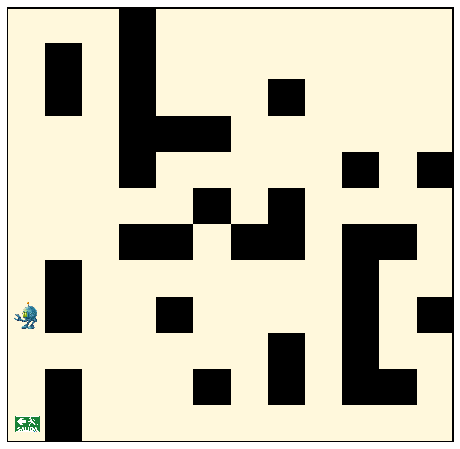

In [41]:
inicia = (0,3)
lab = Laberinto(inicia)
s   = lab.estado_inicial
lab.pintar_estado(s)

Observe que el método `pintar_camino()` permite visualizar el movimiento del agente dentro del laberinto:

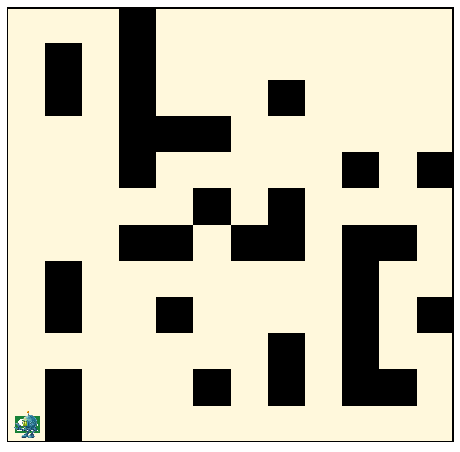

In [42]:
camino = [(0,3), (0,2), (0,1), (0,0)]
lab.pintar_camino(camino)

<a class="anchor" id="ej9"></a>**Ejercicio 9:** 

([Anterior ejercicio](#ej8))

Resuelva el problema del laberinto iniciando en la casilla $(11,11)$ mediante los métodos:

* `breadth_first_search`
* `depth_first_search`
* `depth_limited_search`
* `best_first_search` con la función de costo uniforme. 

Responda a las siguientes dos preguntas: ¿Cuál es más rápido? ¿Cuál da una solución óptima?

               sum_sq     df            F         PR(>F)
C(Función)  77.169948    3.0  6792.581951  3.983590e-130
Residual     0.439289  116.0          NaN            NaN


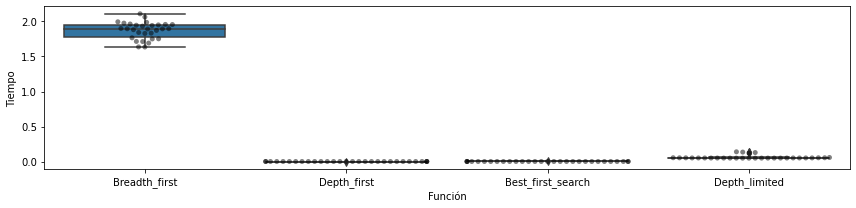

In [43]:
funs = [breadth_first_search,
        depth_first_search,
        lambda x: best_first_search(x, costo_uniforme),
        lambda x: depth_limited_search(x, 10)]

nombres = ['Breadth_first', 'Depth_first', 
           'Best_first_search', 'Depth_limited']

prob = Laberinto((11,11))
data = compara_funciones(funs=funs, arg=prob, nombres=nombres)

# Graficando
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data, x='Función', y='Tiempo')
sns.swarmplot(data=data, x='Función', y='Tiempo', color='black', alpha = 0.5, ax=ax);

# Anova diferencia de medias
model = ols('Tiempo ~ C(Función)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

---

## En este notebook usted aprendió

* Cómo realizar una búsqueda mediante los métodos *depth_limited* e *iterative_deepening* e implementarlos en python.
* Cómo implementar una lista prioritaria en Python.
* La incorporación del costo de las acciones y el costo del camino asociado a un nodo en un árbol de búsqueda.
